<h1>A Feature Prototype</h1>

This feature prototype represent a function in the traffic sign detection system: The traffic sign recognition.

This feature is meant to detech and classify the traffic sign show in a picture. However, this is the second stage of the complete funcional traffic sign detection system which includes detecting and selecting the traffic sign and then classfifying the traffic sign detected.

<h2>1. Data preparetion</h2>

Firstly, the dataset is obtained from [here](https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/published-archive.html), the German Traffic Sign Recognition Benchmark GTSRB dataset. The file downloaded includes training images with lable, test images, and ground truth for the test images.

The path to the dataset is loaded below:

In [1]:
# Load the dataset
train_directory = r'C:\Users\xjie\Documents\SIM\Final\project\GTSRB\GTSRB-Training_fixed\GTSRB\Training'
# Path to the CSV file containing the testing labels
ground_truth = r"C:\Users\xjie\Documents\SIM\Final\project\GTSRB\GTSRB_Final_Test_GT\GT-final_test.csv"
# Path to the test image directory
test_directory = r'C:\Users\xjie\Documents\SIM\Final\project\GTSRB\GTSRB_Final_Test_Images\GTSRB\Final_Test\Images'

Some libraries is needed for training the model:

In [2]:
import os
import glob
import cv2
import numpy as np
import pandas as pd

from PIL import Image
import shutil

import random
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import accuracy_score
from keras.models import Sequential
from tensorflow.keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers

from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical

from tensorflow.keras.applications import ResNet50 
from keras.optimizers import Adam

from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import ModelCheckpoint

The test images is first extracted and stored as numpy arrays:

In [3]:
# Use the 'glob' module to find all image files in the subdirectories
image_paths = glob.glob(os.path.join(train_directory, '**', '*.ppm'), recursive=True)

images = []
labels = []

for image_path in image_paths:
    # Read the image using OpenCV
    image = cv2.imread(image_path)
    # Resize the image to 32x32 pixels
    image = cv2.resize(image, (32, 32))
    # Normalize the pixel values to the range [0, 1]
    image = image.astype('float32') / 255.0
    images.append(image)

    # Extract the label from the image path
    label = int(image_path.split(os.sep)[-2])
    labels.append(label)

# Convert the lists to NumPy arrays for easier manipulation
images = np.array(images)
labels = np.array(labels)

print("Loaded", len(images), "images and", len(labels), "labels.")

Loaded 26640 images and 26640 labels.


Ground truth for every test file is also loaded in a pandas dataframe:

In [4]:
# Read the CSV file into a pandas DataFrame
ground_truth_df = pd.read_csv(ground_truth, delimiter=";")

# Print the loaded DataFrame
print(ground_truth_df.head())

    Filename  Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId
0  00000.ppm     53      54       6       5      48      49       16
1  00001.ppm     42      45       5       5      36      40        1
2  00002.ppm     48      52       6       6      43      47       38
3  00003.ppm     27      29       5       5      22      24       33
4  00004.ppm     60      57       5       5      55      52       11


Test images are extracted and stored in numpy dataframe:

In [5]:
# Get the list of test image file names
test_files = sorted(os.listdir(test_directory))

# Initialize an empty list to store the test images
test_images = []

# Iterate over the test files
for test_file in test_files:
    # Construct the full path to the test image
    image_path = os.path.join(test_directory, test_file)

    # Read the test image using OpenCV
    image = cv2.imread(image_path)

    
    # Check if the image is empty
    if image is None:
        print(f"Skipping file: {image_path}")
        continue
        
    # Resize the image to 32x32 pixels
    image = cv2.resize(image, (32, 32))

    # Normalize the pixel values to the range [0, 1]
    image = image.astype('float32') / 255.0

    # Append the image to the list of test images
    test_images.append(image)

# Convert the list of test images to a NumPy array
test_images = np.array(test_images)

print("Loaded", len(test_images), "test images.")

Skipping file: C:\Users\xjie\Documents\SIM\Final\project\GTSRB\GTSRB_Final_Test_Images\GTSRB\Final_Test\Images\GT-final_test.test.csv
Loaded 12630 test images.


The lable to be predicted will be the class ids stored in the ground truth dataframe.:

In [6]:
# Extract the class IDs from the ground_truth_df DataFrame
class_ids = ground_truth_df['ClassId'].values

# Assign X_test as the test_images array
X_test = test_images

# Assign y_test as the class_ids array
y_test = class_ids

The shape of training and testing dataset is checked:

In [7]:
print("Training dataset:")
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)
print("="*20)
print("Testing dataset:")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Training dataset:
Images shape: (26640, 32, 32, 3)
Labels shape: (26640,)
Testing dataset:
X_test shape: (12630, 32, 32, 3)
y_test shape: (12630,)


To visualise the data, a random sample of 3 images from 10 random classes in training dataset:

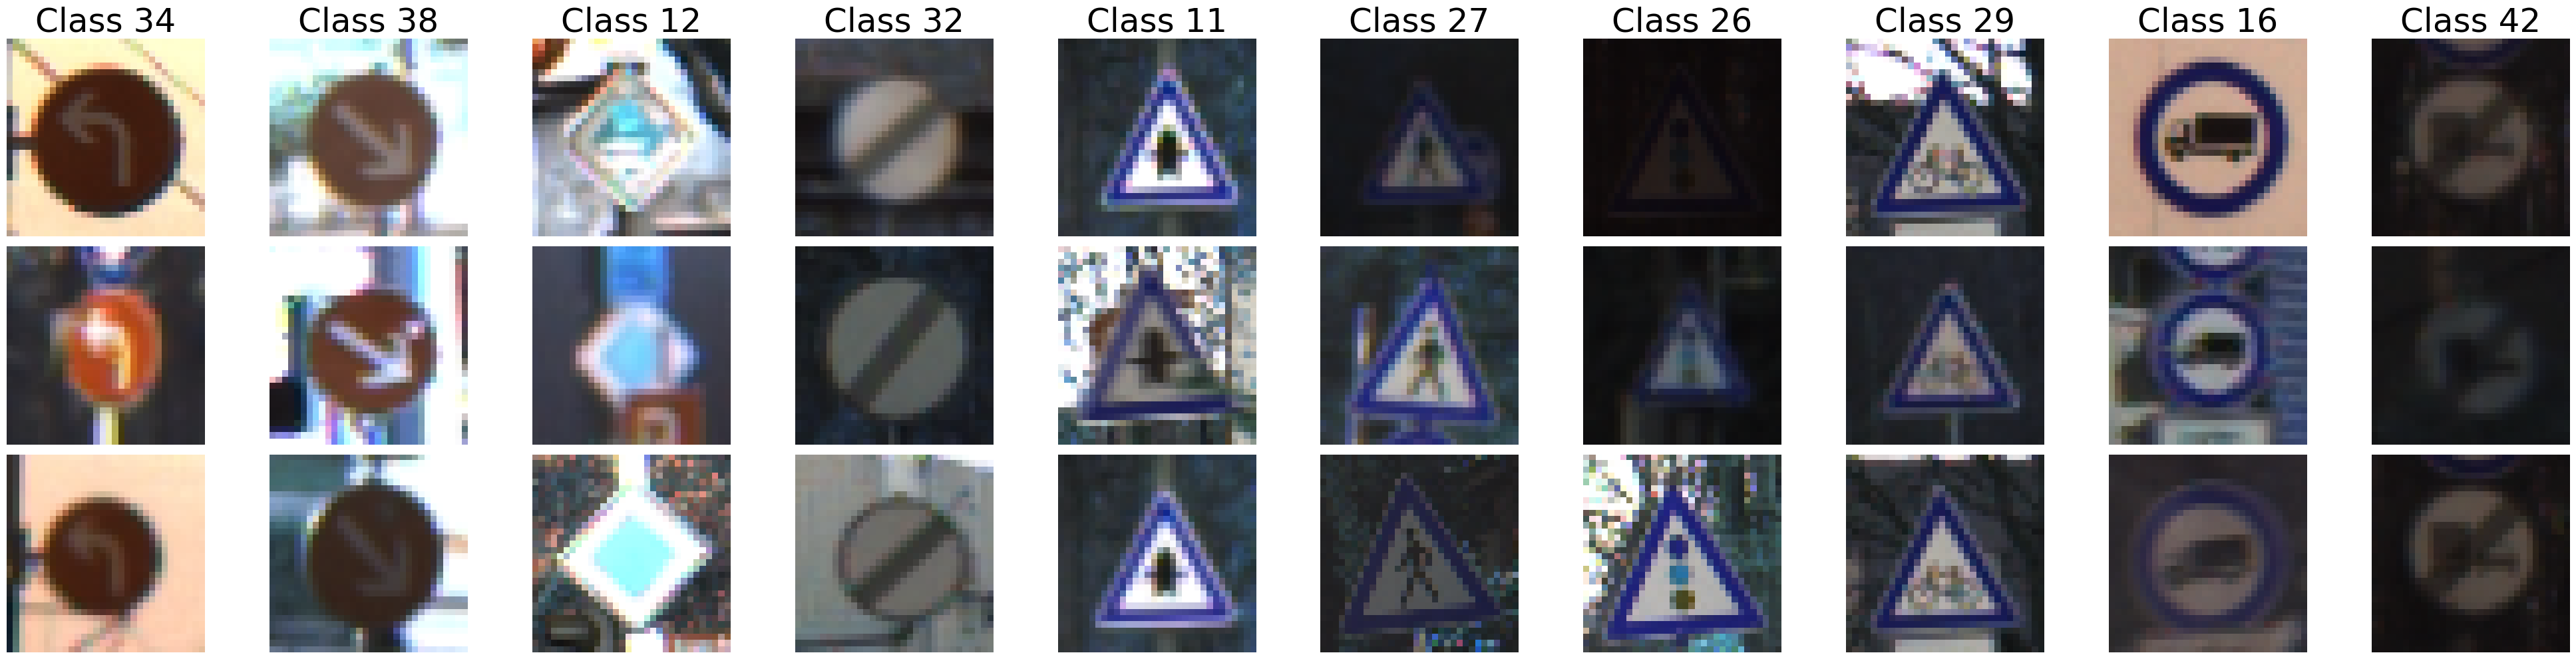

In [8]:
import random
import matplotlib.pyplot as plt

# Select 10 random class IDs from the training data
random_classes = random.sample(list(set(labels)), k=10)

# Create a subplot grid for the images
fig, axes = plt.subplots(nrows=3, ncols=len(random_classes), figsize=(4 * len(random_classes), 10))

# Iterate over the random class IDs
for i, class_id in enumerate(random_classes):
    # Find the indices of images in the training data belonging to the current class
    class_indices = np.where(labels == class_id)[0]

    # Randomly select 3 image indices for display
    random_indices = random.sample(list(class_indices), k=3)

    # Display the class label at the top of the column
    axes[0, i].set_title(f"Class {class_id}", fontsize = 36)

    # Iterate over the random image indices
    for j, image_index in enumerate(random_indices):
        # Get the corresponding image
        image = images[image_index]

        # Display the image
        axes[j, i].imshow(image)
        axes[j, i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()


<h2>2. Training and testing of model</h2>

The number of classes to be predicted/trained is set to be 43 which is the number of classes present in training dataset.

In [9]:
num_classes=43

The images and labels for training are splited into training and validation data. Their respecitive shape is checked:

In [10]:
# Split the training dataset
X_train, X_val, y_train, y_val = train_test_split(images, labels)

In [11]:
print("Training dataset:")
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

Training dataset:
X_train shape: (19980, 32, 32, 3)
X_val shape: (6660, 32, 32, 3)
y_train shape: (19980,)
y_val shape: (6660,)


A function is defined to show the histories in training and validation accuracy. This is to access if the model overfit:

In [12]:
def plot_training_history(history):
    # Access the training history
    training_loss = history.history['loss']
    training_accuracy = history.history['accuracy']
    validation_loss = history.history['val_loss']
    validation_accuracy = history.history['val_accuracy']

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plotting the training and validation accuracy
    ax1.plot(training_accuracy)
    ax1.plot(validation_accuracy)
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Train', 'Validation'], loc='upper left')

    # Plotting the training and validation loss
    ax2.plot(training_loss)
    ax2.plot(validation_loss)
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(['Train', 'Validation'], loc='upper right')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the figure
    plt.show()

<h3>Baseline model:</h3>

ResNet-50 is a specific variant of the ResNet (Residual Network) architecture. It is used commonly for image classification tasks. Thus, this will be implementing a transfered learning based on RestNet50 in attempt to achieve a higher accuracy:

In [13]:
base_model = ResNet50(include_top=False, input_shape=(32, 32, 3))
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))

In [14]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
checkpoint = ModelCheckpoint('ResNet50model_checkpoint.h5', save_best_only=True)
RestNet50_model=model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
625/625 [==============================] - 514s 817ms/step - loss: 1.7853 - accuracy: 0.5162 - val_loss: 3.9604 - val_accuracy: 0.1713
Epoch 2/10
625/625 [==============================] - 517s 828ms/step - loss: 0.6271 - accuracy: 0.8282 - val_loss: 2.8922 - val_accuracy: 0.3631
Epoch 3/10
625/625 [==============================] - 515s 824ms/step - loss: 0.5463 - accuracy: 0.8593 - val_loss: 2.7194 - val_accuracy: 0.3062
Epoch 4/10
625/625 [==============================] - 549s 878ms/step - loss: 0.5758 - accuracy: 0.8425 - val_loss: 0.5186 - val_accuracy: 0.8586
Epoch 5/10
625/625 [==============================] - 522s 835ms/step - loss: 0.4068 - accuracy: 0.8982 - val_loss: 0.2447 - val_accuracy: 0.9311
Epoch 6/10
625/625 [==============================] - 546s 873ms/step - loss: 0.5372 - accuracy: 0.8585 - val_loss: 0.1190 - val_accuracy: 0.9653
Epoch 7/10
625/625 [==============================] - 552s 883ms/step - loss: 0.2827 - accuracy: 0.9274 - val_loss: 7.0041 -

In [16]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

395/395 [==============================] - 20s 48ms/step - loss: 0.5653 - accuracy: 0.8858
Test Loss: 0.5653432011604309
Test Accuracy: 0.8858274221420288


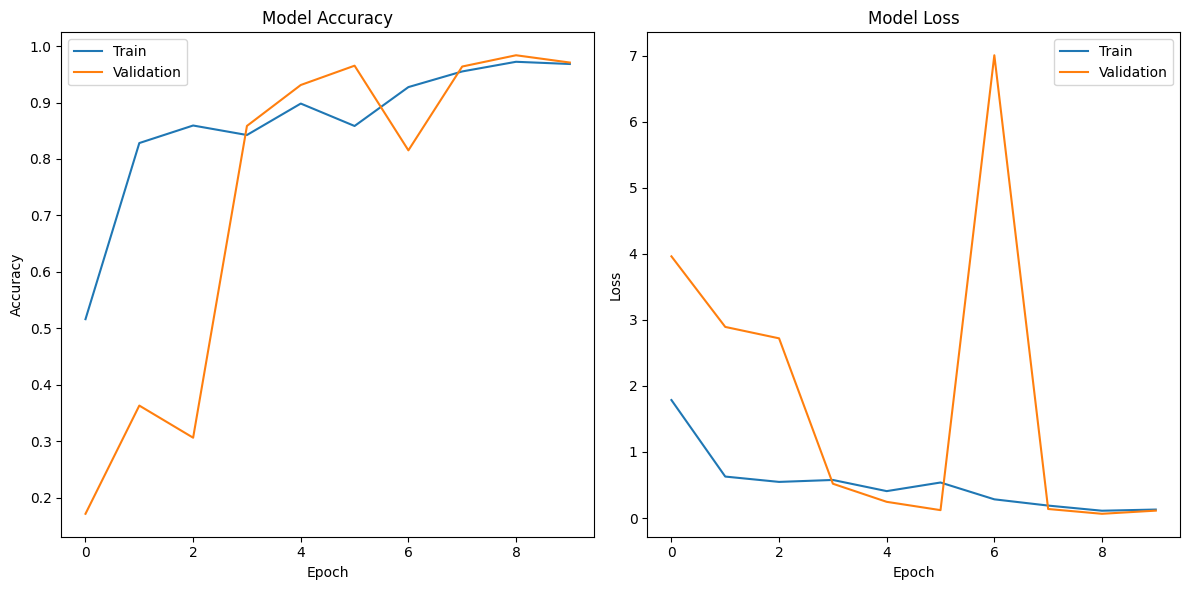

In [17]:
plot_training_history(RestNet50_model)

The basic implementaion of RestNet 50 model showed a 87% accuracy. This is close to our estimation of 90% accuracy.

<h3>Deploying CNN model:</h3>

Firstly, a model is defined for training a convolution neural network for a image classfication task.
Conv2D is used feature extraction in images, input shape is set as the size of the image (32)
Maxpooling2D is used for dimensonality reduction.
Flatten is used to change the infort format to 1D for dense layer.

The category is obtained using softmax activation to 43 classes (num_classes) on a dense layer.

Dropout were added but no regularisation is used yet.

In [18]:
# Build the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

In [20]:
# Build the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
# Train the model
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

num_epochs = 20
batch_size = 32
history_cnn = model.fit(X_train, y_train_cat, validation_data=(X_val, y_val_cat), epochs=num_epochs, batch_size=batch_size, callbacks=[early_stopping])

Epoch 1/20
625/625 [==============================] - 8s 13ms/step - loss: 1.2398 - accuracy: 0.6662 - val_loss: 0.3408 - val_accuracy: 0.9221
Epoch 2/20
625/625 [==============================] - 7s 11ms/step - loss: 0.2133 - accuracy: 0.9491 - val_loss: 0.1415 - val_accuracy: 0.9689
Epoch 3/20
625/625 [==============================] - 7s 11ms/step - loss: 0.0999 - accuracy: 0.9768 - val_loss: 0.1054 - val_accuracy: 0.9757
Epoch 4/20
625/625 [==============================] - 7s 11ms/step - loss: 0.0623 - accuracy: 0.9849 - val_loss: 0.1065 - val_accuracy: 0.9676
Epoch 5/20
625/625 [==============================] - 7s 12ms/step - loss: 0.0511 - accuracy: 0.9881 - val_loss: 0.1173 - val_accuracy: 0.9734
Epoch 6/20
625/625 [==============================] - 7s 11ms/step - loss: 0.0339 - accuracy: 0.9917 - val_loss: 0.1130 - val_accuracy: 0.9758


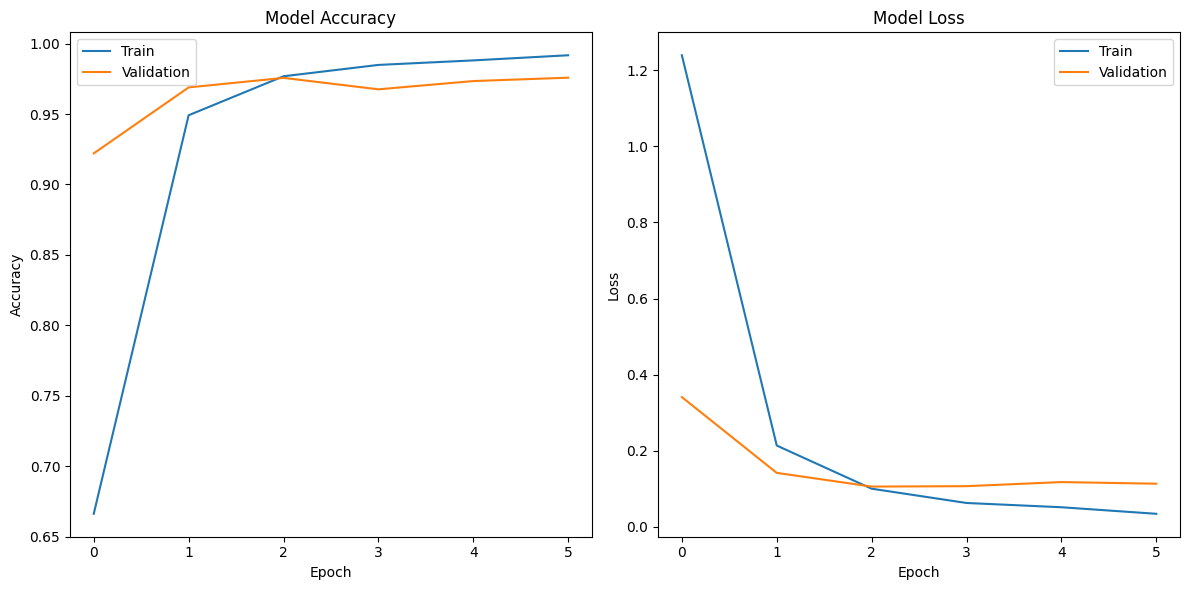

In [22]:
plot_training_history(history_cnn)

The model complexity can be <b>further increased</b> as the validation accuracy does not show a decrease.

In [23]:
# Evaluate the model
y_test_encoded = to_categorical(y_test, num_classes=num_classes)
_, accuracy = model.evaluate(X_test, y_test_encoded)
print('Test accuracy: {:.2f}%'.format(accuracy * 100))

395/395 [==============================] - 2s 4ms/step - loss: 0.6051 - accuracy: 0.8854
Test accuracy: 88.54%
